<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#t-SNE-Explorations" data-toc-modified-id="t-SNE-Explorations-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>t-SNE Explorations</a></span><ul class="toc-item"><li><span><a href="#Plotting-function" data-toc-modified-id="Plotting-function-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Plotting function</a></span></li><li><span><a href="#Generate-the-data" data-toc-modified-id="Generate-the-data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Generate the data</a></span></li><li><span><a href="#Prep-the-data-for-fitting-and-visualizing" data-toc-modified-id="Prep-the-data-for-fitting-and-visualizing-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Prep the data for fitting and visualizing</a></span></li><li><span><a href="#3D-view" data-toc-modified-id="3D-view-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>3D view</a></span></li><li><span><a href="#Dumb-2D-projection" data-toc-modified-id="Dumb-2D-projection-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Dumb 2D projection</a></span></li><li><span><a href="#PCA-(2D)" data-toc-modified-id="PCA-(2D)-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>PCA (2D)</a></span></li><li><span><a href="#NMF" data-toc-modified-id="NMF-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>NMF</a></span></li><li><span><a href="#ICA" data-toc-modified-id="ICA-1.8"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>ICA</a></span></li><li><span><a href="#Isomap" data-toc-modified-id="Isomap-1.9"><span class="toc-item-num">1.9&nbsp;&nbsp;</span>Isomap</a></span></li><li><span><a href="#Locally-Linear-Embedding" data-toc-modified-id="Locally-Linear-Embedding-1.10"><span class="toc-item-num">1.10&nbsp;&nbsp;</span>Locally Linear Embedding</a></span></li><li><span><a href="#Spectral-Embedding" data-toc-modified-id="Spectral-Embedding-1.11"><span class="toc-item-num">1.11&nbsp;&nbsp;</span>Spectral Embedding</a></span></li><li><span><a href="#Multi-dimensional-scaling-(MDS)" data-toc-modified-id="Multi-dimensional-scaling-(MDS)-1.12"><span class="toc-item-num">1.12&nbsp;&nbsp;</span>Multi-dimensional scaling (MDS)</a></span></li><li><span><a href="#t-SNE-(2D)" data-toc-modified-id="t-SNE-(2D)-1.13"><span class="toc-item-num">1.13&nbsp;&nbsp;</span>t-SNE (2D)</a></span></li><li><span><a href="#PCA-(3D)" data-toc-modified-id="PCA-(3D)-1.14"><span class="toc-item-num">1.14&nbsp;&nbsp;</span>PCA (3D)</a></span></li><li><span><a href="#t-SNE-(3D)" data-toc-modified-id="t-SNE-(3D)-1.15"><span class="toc-item-num">1.15&nbsp;&nbsp;</span>t-SNE (3D)</a></span></li></ul></li><li><span><a href="#UMAP" data-toc-modified-id="UMAP-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>UMAP</a></span></li></ul></div>

# t-SNE Explorations

In [1]:
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, NMF, FastICA
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding, MDS, SpectralEmbedding


np.set_printoptions(suppress=True)
np.set_printoptions(precision=4)
plt_style = 'seaborn-talk'
# pip install umap-learn
# pip install hdbscan
hdbscan_available = True
try:
    import hdbscan
except ImportError:
    hdbscan_available = False
    
# pip install umap-learn
umap_available = True
try:
    import umap
except ImportError:
    umap_available = False

## Plotting function

In [2]:
def do_plot(X_fit, title=None, labels=None):
    dimension = X_fit.shape[1]
    label_types = sorted(list(set(labels)))
    num_labels = len(label_types)
    colors = cm.Accent(np.linspace(0, 1, num_labels))
    with plt.style.context(plt_style):
        fig = plt.figure()
        if dimension == 2:
            ax = fig.add_subplot(111)
            for lab, col in zip(label_types, colors):
                ax.scatter(X_fit[labels==lab, 0],
                           X_fit[labels==lab, 1],
                           c=[col])
        elif dimension == 3:
            ax = fig.add_subplot(111, projection='3d')
            for lab, col in zip(label_types, colors):
                ax.scatter(X_fit[labels==lab, 0],
                           X_fit[labels==lab, 1],
                           X_fit[labels==lab, 2],
                           c=[col])
        else:
            raise Exception('Unknown dimension: %d' % dimension)
        plt.title(title)
        plt.show()

## Generate the data
To create a simple test case, we generate some Gaussian point clouds in $\mathbb{R}^3$. Then we see how they look embedded in $\mathbb{R}^2$ and $\mathbb{R}^3$ using various algorithms, including t-SNE.

There's one point cloud centered at the origin and three on each of the three axes. They are well separated, as can be seen in the first visualization below.

In [3]:
num_dimensions = 3
num_clusters = 4
num_points = 100
cluster_separation = 6
centers = np.array([(0,0,0), (1,0,0), (0,1,0), (0,0,1)], dtype=float) * cluster_separation
data = np.zeros((num_clusters * num_points, num_dimensions), dtype=float)
labels = np.zeros(num_clusters * num_points, dtype=int)
for c in range(num_clusters):
    start = c * num_points
    end = start + num_points
    data[start:end, :] = np.random.randn(num_points, num_dimensions) + centers[c]
    labels[start:end] = c
data_df = pd.DataFrame(data, columns=('x','y','z'))
data_df['label'] = labels
data_df.head()

,x,y,z,label
0,0.503518,-0.213135,-0.161143,0
1,0.287452,0.726255,-0.039546,0
2,0.216994,-1.020743,-0.023893,0
3,0.569440,-0.712724,0.551503,0
4,0.731494,0.731889,0.061457,0


## Prep the data for fitting and visualizing

In [4]:
X = data_df.iloc[:,0:-1]
X_std = StandardScaler().fit_transform(X)
y = data_df['label'].values

In [5]:
labels = data_df['label'].values

In [6]:
label_types = sorted(list(set(labels)))
num_labels = len(label_types)
colors = cm.Accent(np.linspace(0, 1, num_labels))

In [7]:
X.values

array([[ 0.5035, -0.2131, -0.1611],
       [ 0.2875,  0.7263, -0.0395],
       [ 0.217 , -1.0207, -0.0239],
       ...,
       [-0.0007,  1.5485,  5.5724],
       [-1.2918,  0.3821,  3.2195],
       [ 0.2658,  1.2896,  5.6057]])

## 3D view

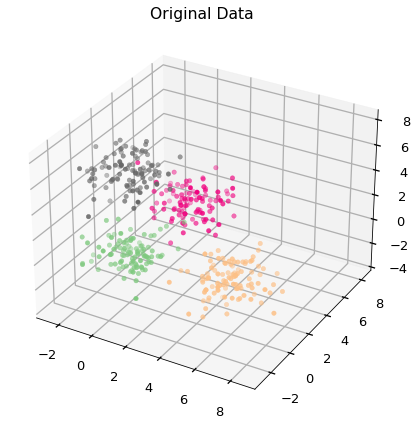

In [8]:
do_plot(X.values, 'Original Data', y)

## Dumb 2D projection
The easiest way to embed our data into two dimensions is to project onto the plane $x=0$.

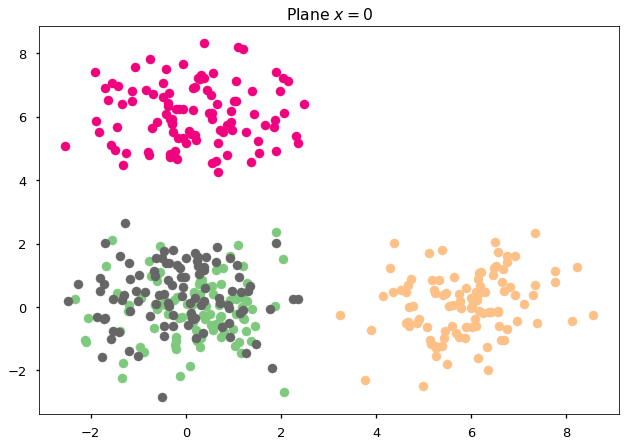

In [11]:
do_plot(X.values[:,0:2], 'Plane $x=0$', labels)

## PCA (2D)

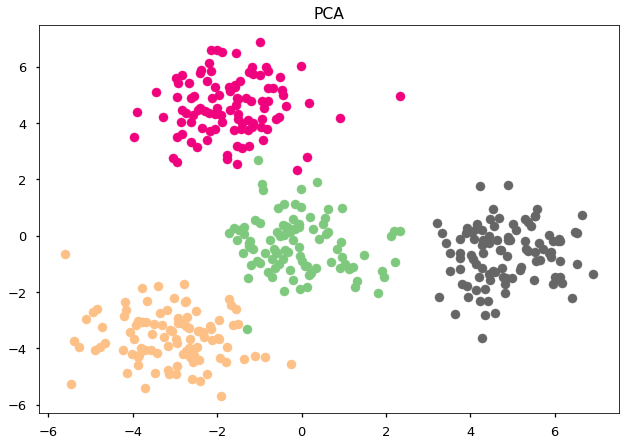

In [12]:
do_plot(PCA(n_components=2).fit_transform(X), 'PCA', labels)

## NMF

In [13]:
do_plot(NMF(n_components=2).fit_transform(X), 'NMF', labels)

ValueError: Negative values in data passed to NMF (input X)

## ICA

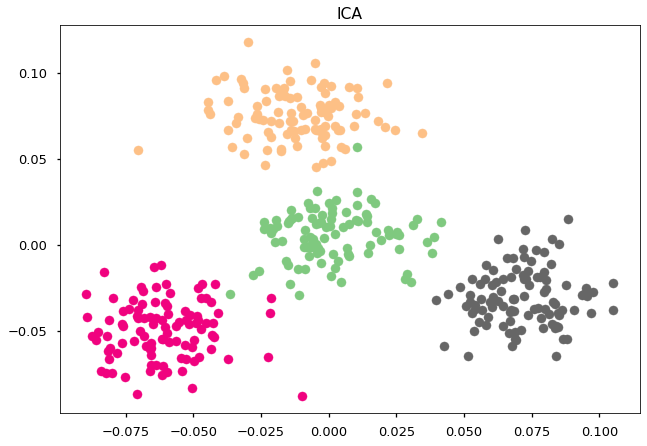

In [15]:
do_plot(FastICA(n_components=2).fit_transform(X), 'ICA', labels)

## Isomap

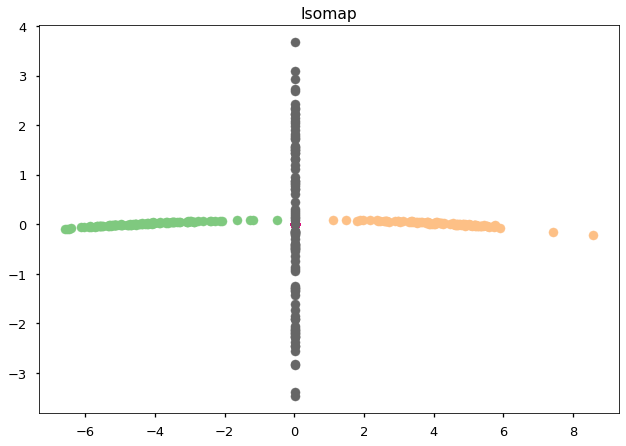

In [14]:
do_plot(Isomap(n_components=2).fit_transform(X), 'Isomap', labels)

## Locally Linear Embedding

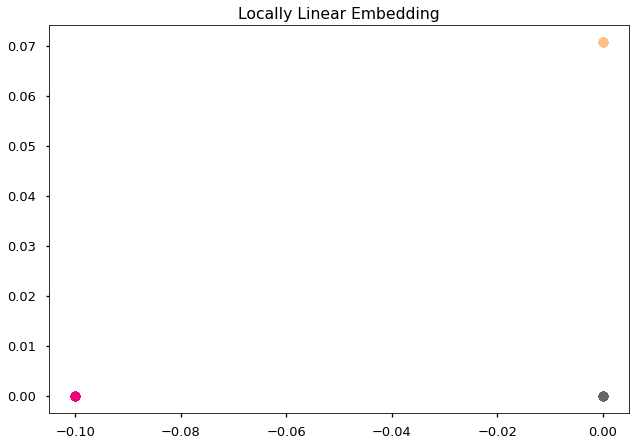

In [15]:
do_plot(LocallyLinearEmbedding(n_components=2).fit_transform(X), 'Locally Linear Embedding', labels)

## Spectral Embedding

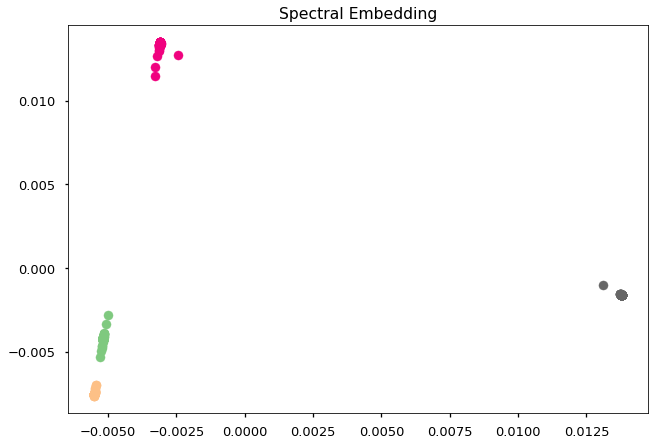

In [16]:
do_plot(SpectralEmbedding(n_components=2).fit_transform(X), 'Spectral Embedding', labels)

## Multi-dimensional scaling (MDS)

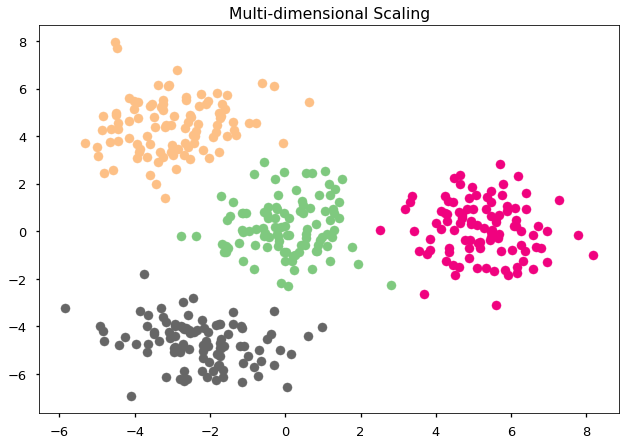

In [17]:
do_plot(MDS(n_components=2).fit_transform(X), 'Multi-dimensional Scaling', labels)

## t-SNE (2D)

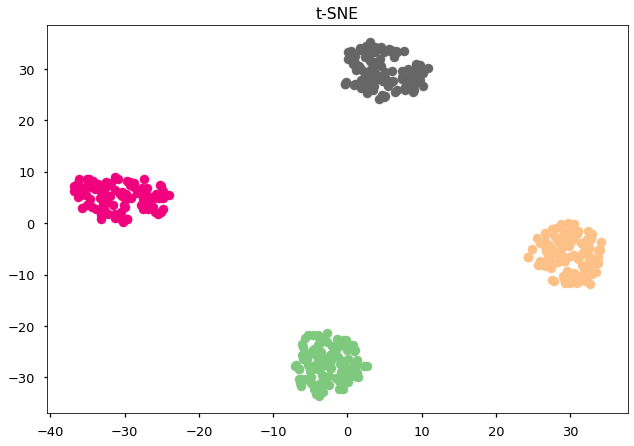

In [18]:
tsne2 = TSNE(n_components=2, random_state=0)
do_plot(tsne2.fit_transform(X), 't-SNE', labels)

## PCA (3D)

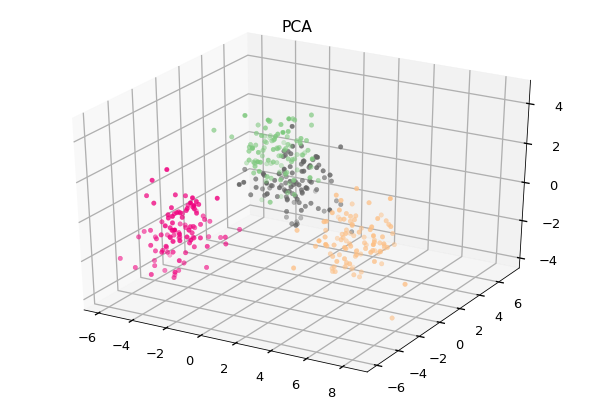

In [19]:
do_plot(PCA(n_components=3).fit_transform(X), 'PCA', labels)

## t-SNE (3D)

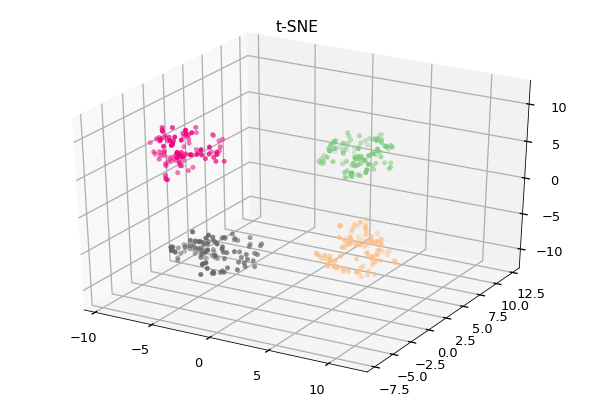

In [20]:
tsne3 = TSNE(n_components=3, learning_rate=100, random_state=0)
do_plot(tsne3.fit_transform(X), 't-SNE', labels)

# UMAP
Uniform Manifold Approximation and Projection (UMAP) is a dimension reduction technique that can be used for visualisation similarly to t-SNE, but also for general non-linear dimension reduction. 

/home/bioinformatica/.local/share/virtualenvs/Ironhack-OdDBNwqQ/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 8 separate connected components using meta-embedding (experimental)
  n_components
/home/bioinformatica/.local/share/virtualenvs/Ironhack-OdDBNwqQ/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


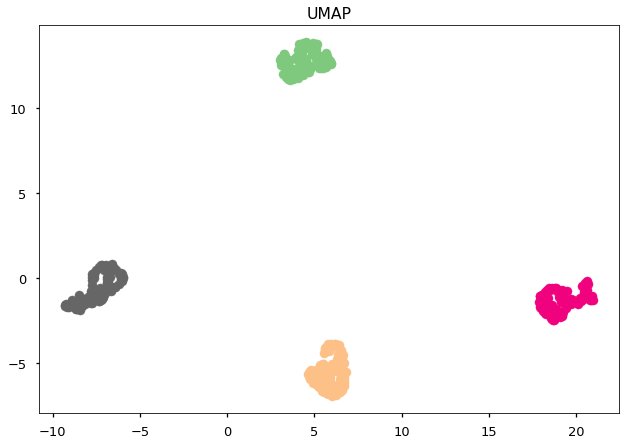

In [22]:
if umap_available:
    embedding = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='correlation').fit_transform(X)
    embedding = umap.UMAP().fit_transform(X)
    do_plot(embedding, 'UMAP', labels)